In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from bigdatavqa.coreset import Coreset

import cudaq

from bigdatavqa.divisiveclustering import (
    DivisiveClusteringKMeans,
    DivisiveClusteringMaxCut,
    DivisiveClusteringRandom,
    DivisiveClusteringVQA,
)

from bigdatavqa.optimizer import get_optimizer_for_VQE, get_optimizer_for_QAOA

from bigdatavqa.vqe_utils import get_VQE_circuit, get_K2_Hamiltonian, get_QAOA_circuit

from bigdatavqa.plot import Voironi_Tessalation, Dendrogram
import warnings

warnings.filterwarnings("ignore")

In [2]:
number_of_qubits = 10
circuit_depth = 1
max_shots = 1000
max_iterations = 100
number_of_coresets_to_evaluate = 15
number_of_sampling_for_centroids = 20
threshold_for_max_cut = 0.7

## Coresets
The next step is to create coreset from the raw data. 

In [3]:
raw_data = Coreset.create_dataset(1000)

coreset = Coreset(
    raw_data=raw_data,
    number_of_sampling_for_centroids=10,
    coreset_size=10,
    number_of_coresets_to_evaluate=4,
    coreset_method="BFL2",
)

coreset_vectors, coreset_weights = coreset.get_best_coresets()

Using BFL2 method to generate coresets


In [4]:
coreset_df = pd.DataFrame(coreset_vectors, columns=list("XY"))
coreset_df["weights"] = coreset_weights
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]
coreset_df

,X,Y,weights,Name
0,1.799140,-2.555512,40.741303,A
1,1.800081,-1.410203,52.711049,B
2,2.706134,-2.636852,19.446129,C
3,-0.644248,0.515479,234.262622,D
4,0.637477,0.156178,98.056119,E
5,5.769898,1.155939,33.630433,F
6,7.115996,1.066844,153.345313,G
7,7.549347,-0.254952,167.678961,H
8,5.369901,3.289151,45.897176,I
9,-1.630099,2.289151,29.826338,J


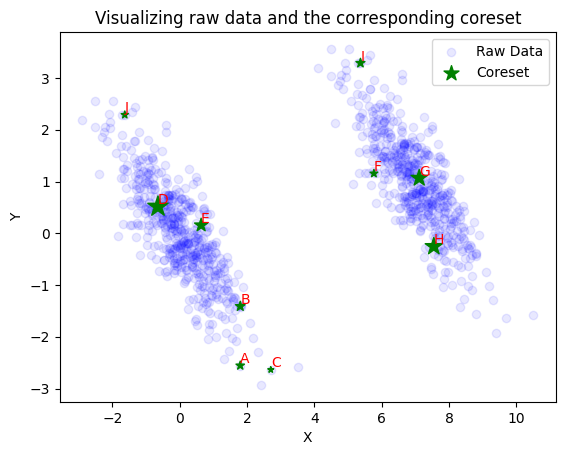

In [5]:
plt.scatter(raw_data[:, 0], raw_data[:, 1], color="blue", alpha=0.09, label="Raw Data")
plt.scatter(
    coreset_df.X, coreset_df.Y, s=coreset_df.weights, marker="*", color="green", label="Coreset"
)
for idx, row in coreset_df.iterrows():
    plt.annotate(row["Name"], xy=(row.X, row.Y + 0.05), color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Visualizing raw data and the corresponding coreset")
plt.show()

## VQE execution

In [6]:
optimizer = cudaq.optimizers.COBYLA()

divisive_clustering = DivisiveClusteringVQA(
    circuit_depth=circuit_depth,
    max_iterations=max_iterations,
    max_shots=max_shots,
    threshold_for_max_cut=0.75,
    create_Hamiltonian=get_K2_Hamiltonian,
    optimizer=optimizer,
    optimizer_function=get_optimizer_for_VQE,
    create_circuit=get_VQE_circuit,
    normalize_vectors=True,
    sort_by_descending=True,
    coreset_to_graph_metric="dist",
)

hierarchial_clustering_sequence_VQE = divisive_clustering.get_divisive_sequence(
    coreset_df, vector_columns=["X", "Y"]
)

VQE_cost = sum(
    divisive_clustering.get_divisive_cluster_cost(
        hierarchial_clustering_sequence_VQE, coreset_df, vector_columns=["X", "Y"]
    )
)

print(f"cost: {VQE_cost}")

100%|██████████| 3/3 [00:00<00:00, 17898.88it/s]

cost: 89.2499065449606


### Exploring results

#### Dendrogram

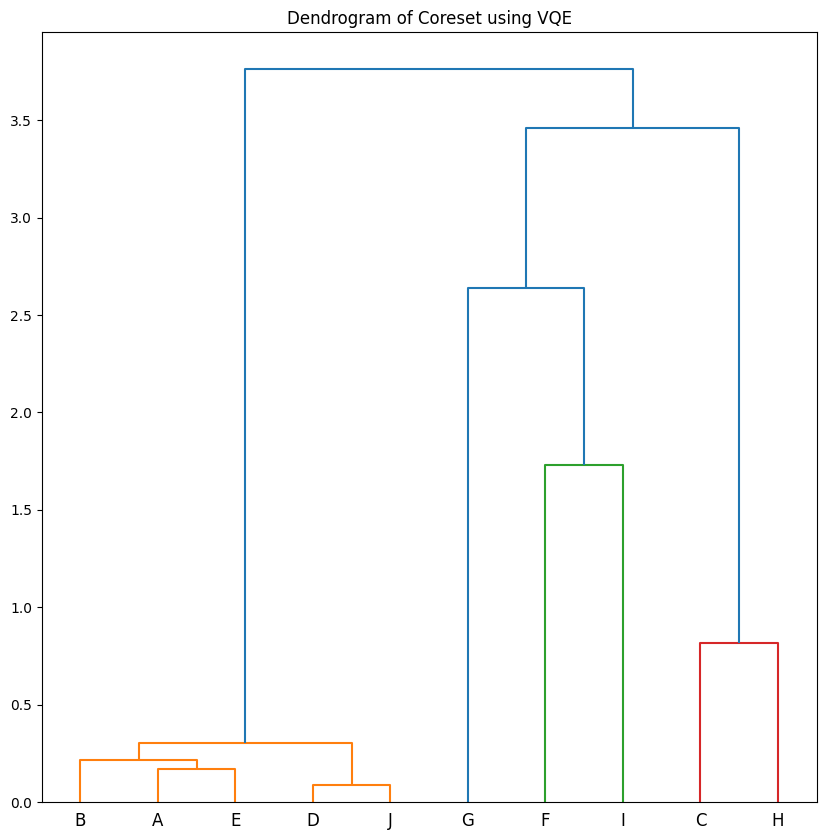

In [7]:
dendo = Dendrogram(coreset_df, hierarchial_clustering_sequence_VQE)
dendo.plot_dendrogram(plot_title="Dendrogram of Coreset using VQE")

#### Viewing the split at each iteration

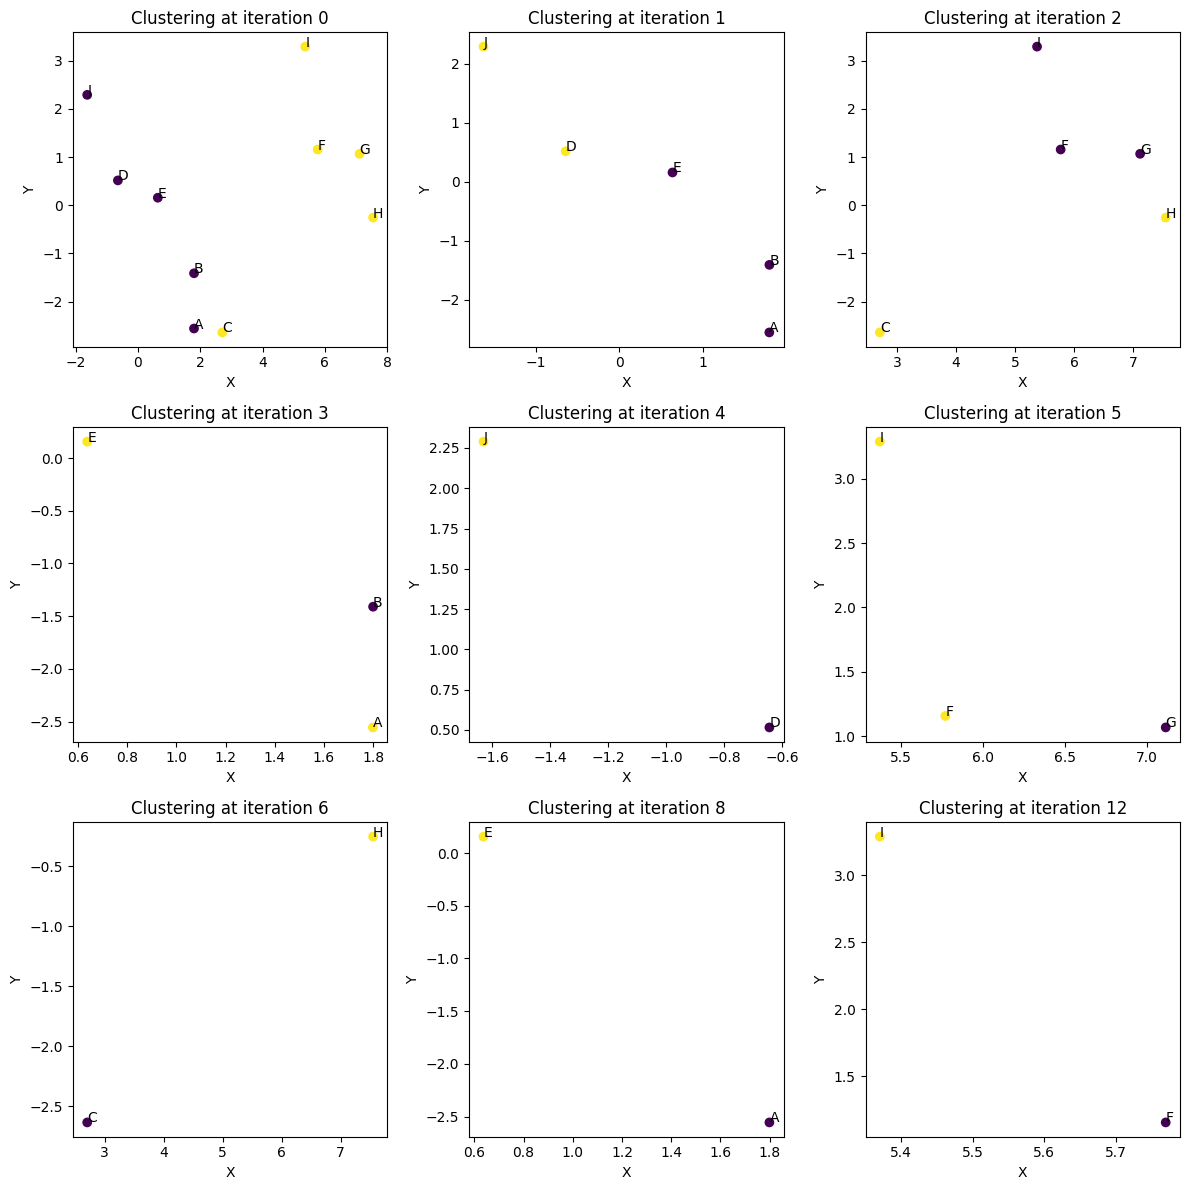

In [8]:
Dendrogram.plot_hierarchial_split(hierarchial_clustering_sequence_VQE, coreset_df)

#### Converting Hierarchical Clustering to Flat Clustering

In [9]:
clusters = dendo.get_clusters_using_height(threshold=2)
print(f"Clusters from height: {clusters}")

Clusters from height: [0 0 3 0 0 1 2 3 1 0]


In [10]:
clusters = dendo.get_clusters_using_k(k=4)
print(f"Clusters from k: {clusters}")

Clusters from k: [0 0 3 0 0 1 2 3 1 0]


### Voronoi Tessellation

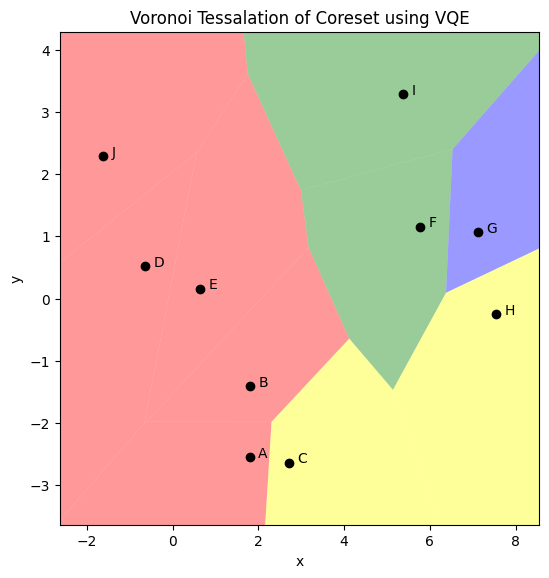

In [11]:
colors = ["red", "green", "blue", "yellow", "purple", "black"]
vt = Voironi_Tessalation(coreset_df.copy(), clusters, colors)
vt.plot_voironi(
    plot_title="Voronoi Tessalation of Coreset using VQE", show_annotation=True, show_scatters=True
)

## QAOA Clustering

In [ ]:
optimizer = cudaq.optimizers.COBYLA()

divisive_clustering = DivisiveClusteringVQA(
    circuit_depth=circuit_depth,
    max_iterations=max_iterations,
    max_shots=max_shots,
    threshold_for_max_cut=0.75,
    create_Hamiltonian=get_K2_Hamiltonian,
    optimizer=optimizer,
    optimizer_function=get_optimizer_for_QAOA,
    create_circuit=get_QAOA_circuit,
    normalize_vectors=True,
    sort_by_descending=True,
    coreset_to_graph_metric="dist",
)

hierarchial_clustering_sequence_QAOA = divisive_clustering.get_divisive_sequence(
    coreset_df, vector_columns=["X", "Y"]
)

QAOA_cost = sum(
    divisive_clustering.get_divisive_cluster_cost(
        hierarchial_clustering_sequence_QAOA, coreset_df, vector_columns=["X", "Y"]
    )
)

print(f"cost: {QAOA_cost}")

## Random clustering

cost: 275.9678626503479


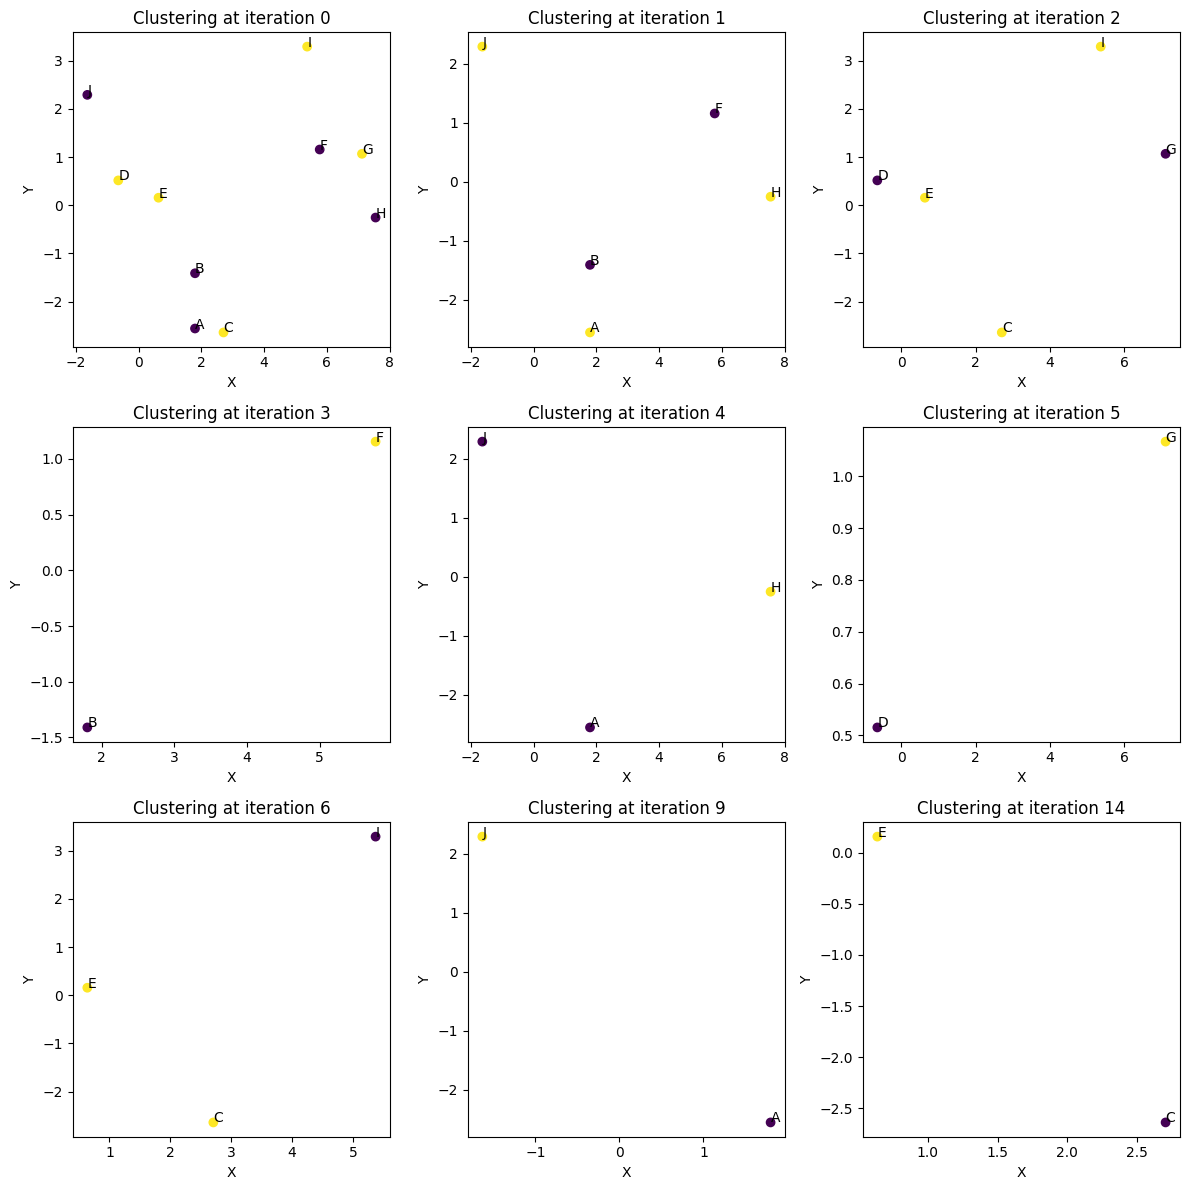

In [12]:
divisive_clustering = DivisiveClusteringRandom()

hierarchial_clustering_sequence_random = divisive_clustering.get_divisive_sequence(
    coreset_df, vector_columns=["X", "Y"]
)

random_cost = sum(
    divisive_clustering.get_divisive_cluster_cost(
        hierarchial_clustering_sequence_random, coreset_df, vector_columns=["X", "Y"]
    )
)

print(f"cost: {random_cost}")

dendo = Dendrogram(coreset_df, hierarchial_clustering_sequence_random)
dendo.plot_hierarchial_split(hierarchial_clustering_sequence_random, coreset_df)

### KMeans clustering

cost: 54.03271110136444


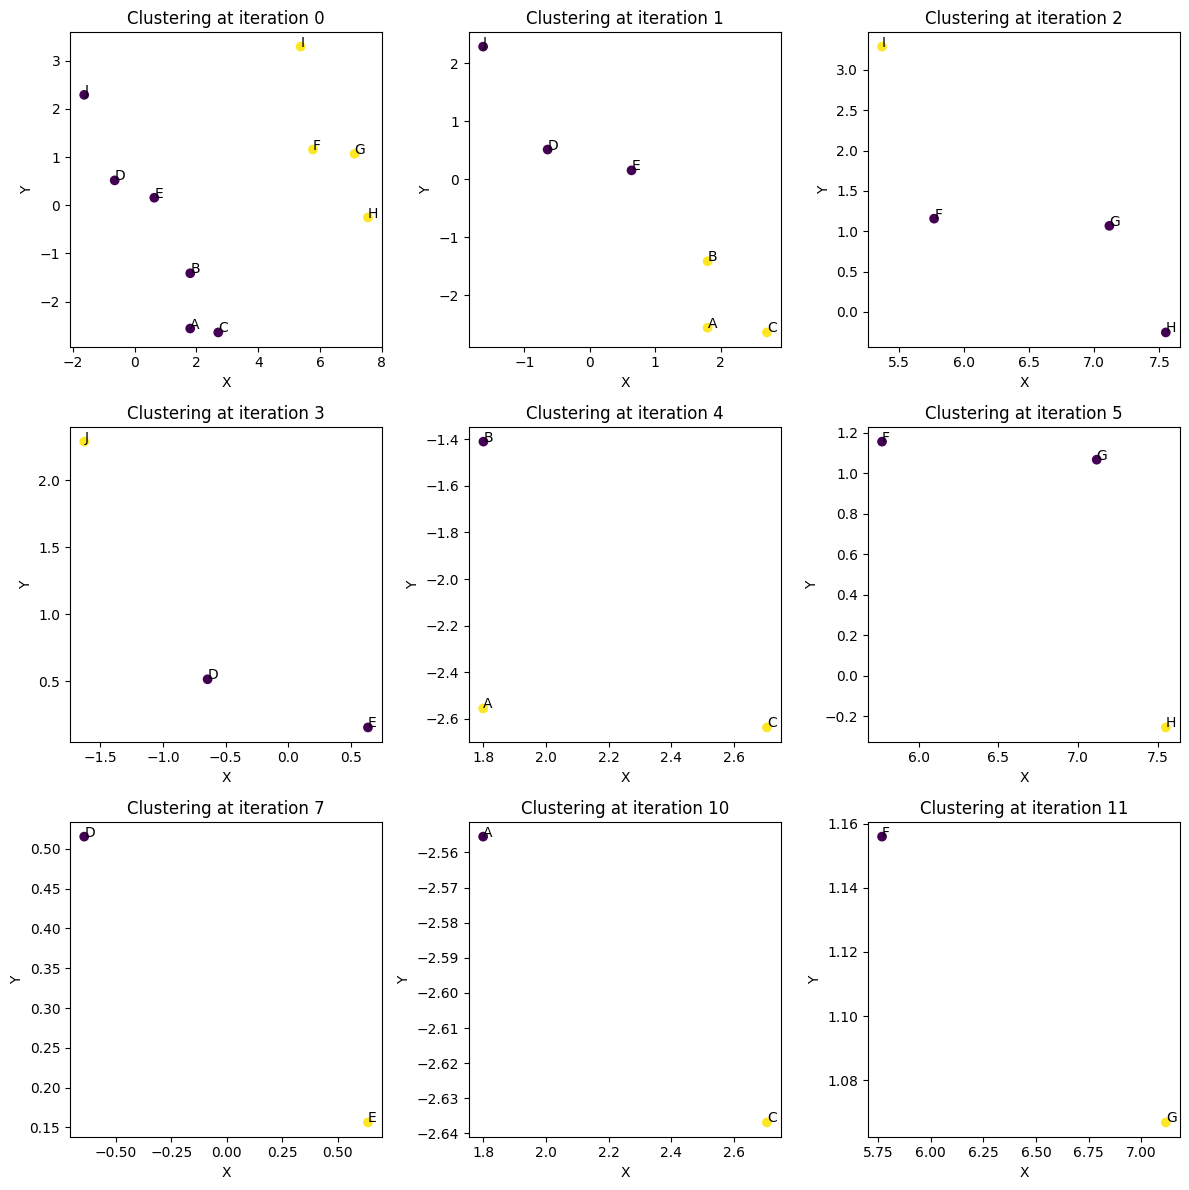

In [13]:
divisive_clustering = DivisiveClusteringKMeans()

hierarchial_clustering_sequence_KMeans = divisive_clustering.get_divisive_sequence(
    coreset_df, vector_columns=["X", "Y"]
)

KMeans_cost = sum(
    divisive_clustering.get_divisive_cluster_cost(
        hierarchial_clustering_sequence_KMeans, coreset_df, vector_columns=["X", "Y"]
    )
)

print(f"cost: {KMeans_cost}")

dendo = Dendrogram(coreset_df, hierarchial_clustering_sequence_KMeans)
dendo.plot_hierarchial_split(hierarchial_clustering_sequence_KMeans, coreset_df)

### MaxCut

In [14]:
divisive_clustering = DivisiveClusteringMaxCut()

hierarchial_clustering_sequence_MaxCut = divisive_clustering.get_divisive_sequence(
    coreset_df, vector_columns=["X", "Y"]
)

MaxCut_cost = sum(
    divisive_clustering.get_divisive_cluster_cost(
        hierarchial_clustering_sequence_MaxCut, coreset_df, vector_columns=["X", "Y"]
    )
)

print(f"cost: {MaxCut_cost}")

100%|██████████| 6/6 [00:00<00:00, 73156.47it/s]

cost: 53.47488238007091


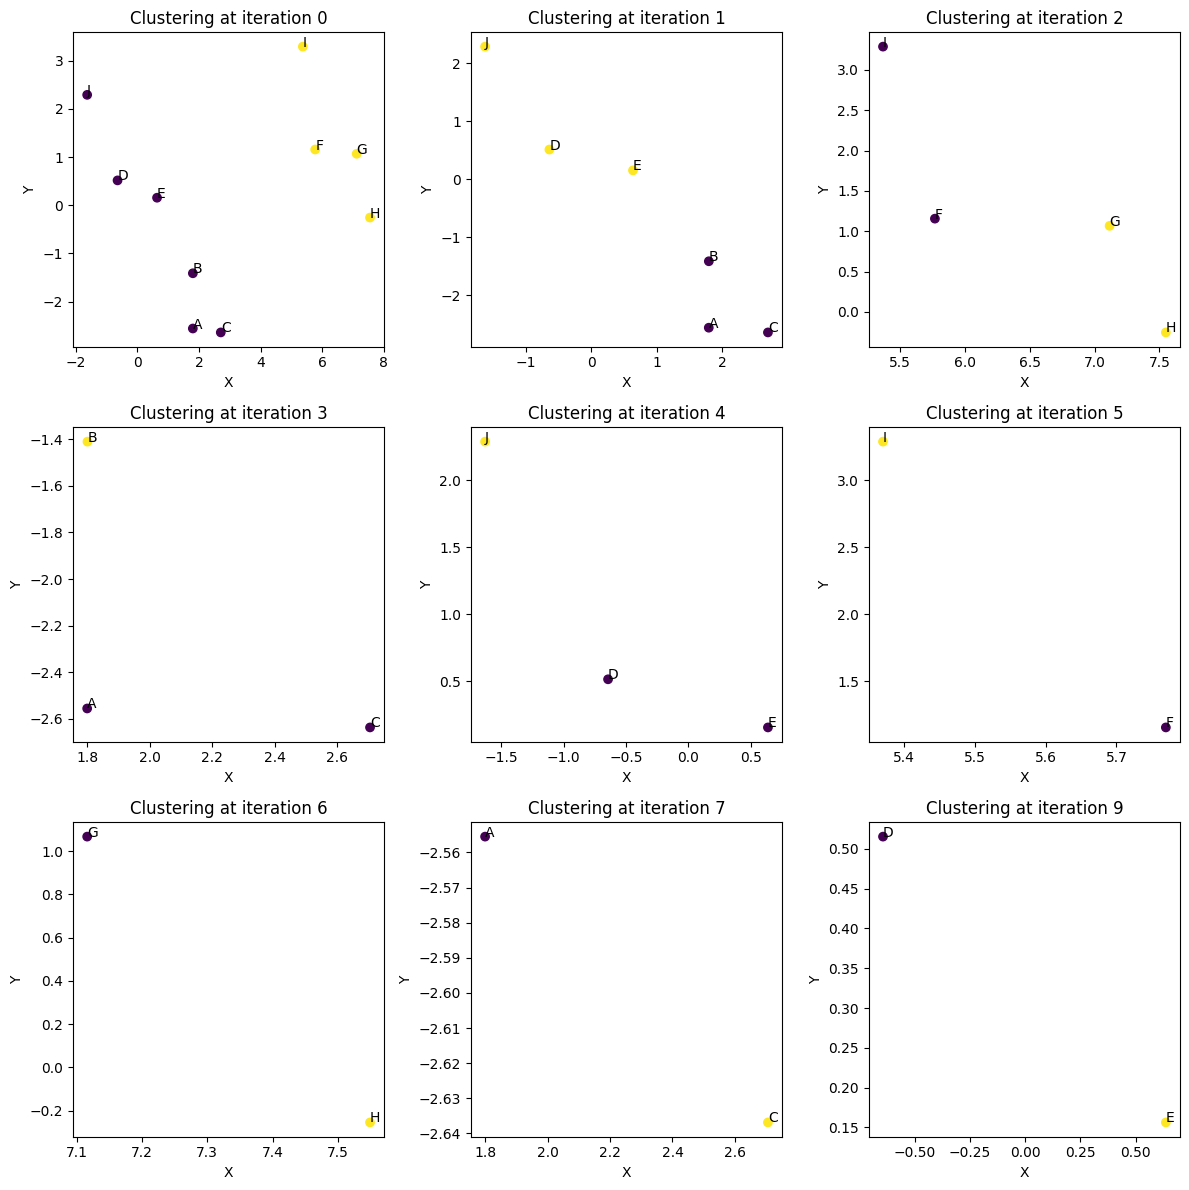

In [15]:
dendo = Dendrogram(coreset_df, hierarchial_clustering_sequence_MaxCut)
dendo.plot_hierarchial_split(hierarchial_clustering_sequence_MaxCut, coreset_df)

## Visualizing the cost output

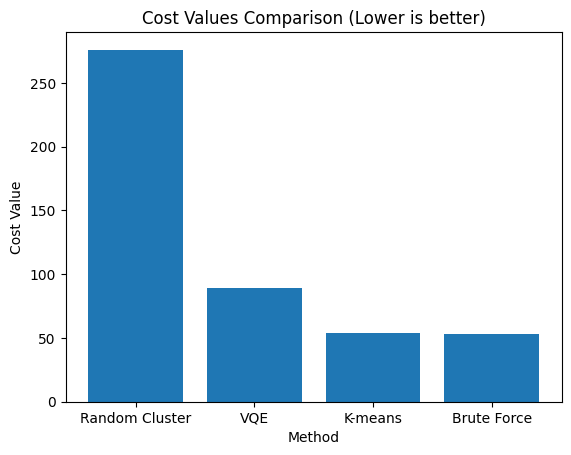

In [16]:
cost_values = [random_cost, VQE_cost, QAOA_cost,KMeans_cost, MaxCut_cost]

labels = ["Random Cluster", "VQE", "QAOA","K-means", "Brute Force"]

plt.bar(labels, cost_values)
plt.xlabel("Method")
plt.ylabel("Cost Value")
plt.title("Cost Values Comparison (Lower is better)")

plt.show()